# KUKA - Document Rectification
This jupyter notebook focus on Perspective rectification and background croping for document type A4,A5
These document may be has background or not ; present full document edges or not



### Reference
- https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning
- https://www.microsoft.com/en-us/research/uploads/prod/2016/12/Whiteboard-It.pdf
- https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
- https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [158]:
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.3.4', 'date': datetime.date(2023, 7, 6)}


## Load image

gray shape: (2560, 1928)


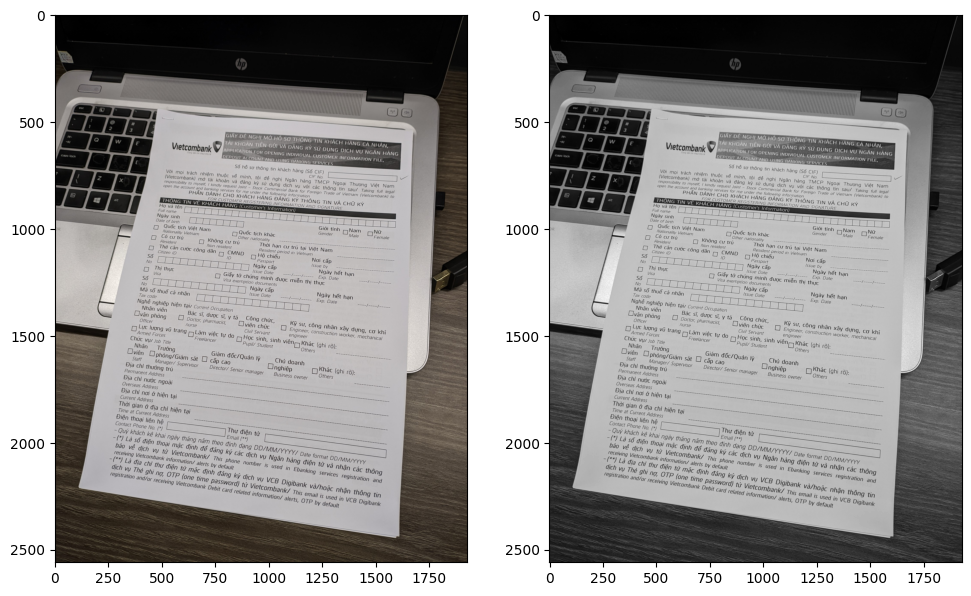

In [402]:
#custom dataset
filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_23.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_25.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_10.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_27.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_28.jpg"

#noise
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train2\TB\img (8-1).jpg"

#smartdoc dataset
#filename=r"D:\ImageData\SmartDoc\background01\datasheet001\frame_50.jpg"

#midv500 dataset
#filename=r"D:\ImageData\midv500\01_alb_id\images\TA\TA01_07.tif"
#filename=r"D:\ImageData\midv500\01_alb_id\images\KA\KA01_07.tif"




src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

print('gray shape:',gray.shape)
figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

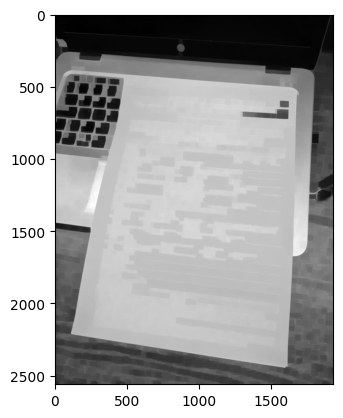

In [403]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [404]:
sobelImg=sobel(blurImg)
#sobelImg=cv2.Canny(blurImg,0,250,apertureSize=3)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line hough probility: 830 - shape:  (830, 1, 4)
edgeImg


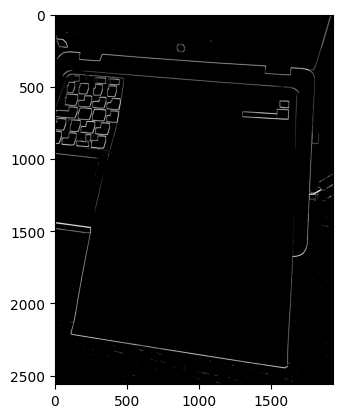

Line image 


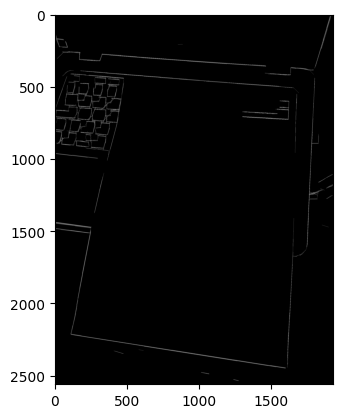

In [405]:
# print debug line
lineImg=np.zeros(src.shape,dtype=np.int8)
if(linesP.any()!=None):
    print('Num of line hough probility:', len(linesP), "- shape: " , linesP.shape )
for line in linesP:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(255,255,255),1)

print("edgeImg")
plt.imshow(edgeImg,cmap='gray')
plt.show()
#plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
print("Line image ")
plt.imshow(lineImg)
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

## Dùng thuật toán đường biên dài nhất
1. Xác dịnh line => dùng houghp đề xác định các line với (x1,y1,x2,y2) => thresold = 1/5 * min(w,h)
2. Clustering lines into groups top / bottom / left/right
2. Fitting line / average line => for each group
    1. chuyển line (x1,y1,x2,y2) => về dạng slopes (b,m)
    2. grouping các line theo (b,m) + khoảng cách giữa các line => được danh sách tham chiếu [line_index] -> [line_in_group]
    3. duyệt theo danh sách tham chiếu => tạo các fitting line
    4. trả lại danh sách sau khi đã fitting
3. Tìm ra quadrangle 
    1. cluster => top/bottom/left/right
    2. soft t/b/l/r line theo length
    3. lấy ra 1 bộ (t,b,l,r) =>lựa chọn quadrangle thỏa mãn các điều kiện về góc va cạnh
- https://sbme-tutorials.github.io/2021/cv/notes/4_week4.html#getting-value-of-rho-and-theta
- https://dsp.stackexchange.com/questions/81992/how-to-convert-a-line-that-goes-through-the-origin-into-hough-space
- https://stackoverflow.com/questions/71811385/how-to-connect-disjointed-lines-or-edges-in-images

Merge line
- https://stackoverflow.com/questions/30746327/get-a-single-line-representation-for-multiple-close-by-lines-clustered-together
- https://answers.opencv.org/question/68781/partition-finding-the-number-of-clusters/


rho_threshold: 5
minline threshold:  50
max_gap_x:  96  max gap y: 128
maxLineGap:  25
minLineLength:  192
total line: 127
edgeImg


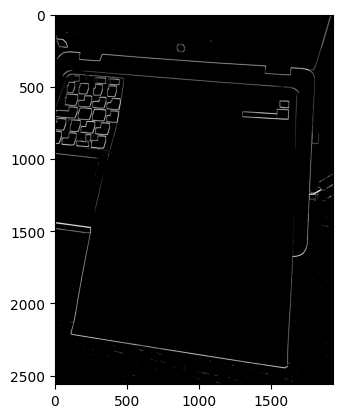

Hough line image


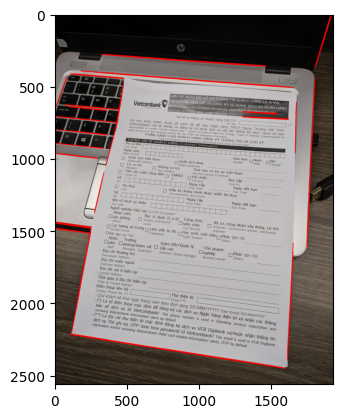

Merged line image


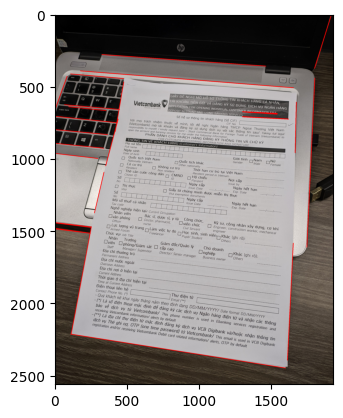

Total merged line:  28
selected line image


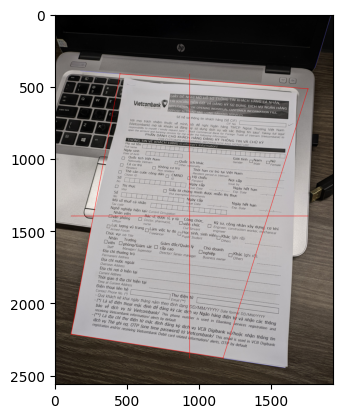

cropped  image


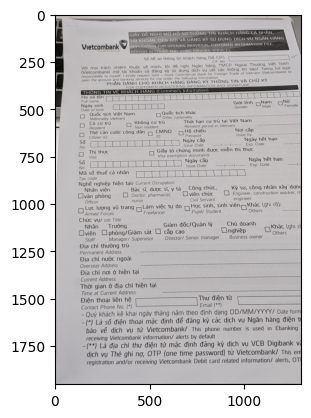

In [413]:


#def cropDocumentTest():
img_height = gray.shape[0]
img_width=gray.shape[1]

topLineList=[]
bottomLineList=[]
leftLineList=[]
rightLineList=[]

topLine_selected=[]
bottomLine_selected=[]
leftLine_selected=[]
rightLine_selected=[]

#program params
rho_threshold =5 #max(0.005*math.sqrt(img_width*img_width+ img_height*img_height),5)
theta_threshold = 1*np.pi/180
max_gap_x = int(0.05*img_width)
max_gap_y = int(0.05*img_height)
minline_threshold  = 50 #int(min(gray.shape[0],gray.shape[1]) /12)
minLineLength =int(0.1*min(img_width,img_height))
maxLineGap = int(0.01*max(img_width,img_height))

print("rho_threshold:",rho_threshold)
print("minline threshold: ",minline_threshold)
print("max_gap_x: ",max_gap_x," max gap y:",max_gap_y)
print("maxLineGap: ",maxLineGap)
print("minLineLength: ",minLineLength)
#get lines by hough
linesP =[]
linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=minline_threshold,minLineLength=minLineLength,maxLineGap=maxLineGap)    
if(linesP.any()!=None and len(linesP)>1):
    print("total line:",len(linesP))

#clustering lines into 4 group
topLineList,bottomLineList,leftLineList,rightLineList=clusteringLineInTBLR(linesP,img_height,img_width)
hasCropped=False
if (len(topLineList)>0 and len(bottomLineList)>0 and len(leftLineList)>0 and len(rightLineList)>0):
    
    # sort line in order befor merging
    topLineList = sortLinePoint(np.squeeze(topLineList,axis=1),sort_axis=0)
    bottomLineList = sortLinePoint( np.squeeze(bottomLineList,axis=1),sort_axis=0)

    leftLineList = sortLinePoint(np.squeeze(leftLineList,axis=1),sort_axis=1)
    rightLineList = sortLinePoint( np.squeeze(rightLineList,axis=1),sort_axis=1)

    #merging
    # convert to slope and merge
    topLineListRhoTheta = convertLinePoint2RhoTheta(topLineList)
    mergedTopLineList = mergingLines(topLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

    bottomLineListRhoTheta = convertLinePoint2RhoTheta(bottomLineList)
    mergedBottomLineList = mergingLines(bottomLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

    leftLineListRhoTheta = convertLinePoint2RhoTheta(leftLineList)
    mergedLeftLineList = mergingLines(leftLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

    rightLineListRhoTheta = convertLinePoint2RhoTheta(rightLineList)
    mergedRightLineList = mergingLines(rightLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

    lineImgDebug = src.copy()
    drawLinePoint(lineImgDebug,topLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,bottomLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,leftLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,rightLineList,(0,0,255),3)


    mergedLineImage = src.copy()
    drawLinePoint(mergedLineImage,mergedTopLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedBottomLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedLeftLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedRightLineList,(0,0,255),3)

    print("edgeImg")
    plt.imshow(edgeImg,cmap='gray')
    plt.show()

    print('Hough line image')
    plt.imshow(cv2.cvtColor(lineImgDebug,cv2.COLOR_BGR2RGB))
    plt.show()

    print('Merged line image')
    plt.imshow(cv2.cvtColor(mergedLineImage,cv2.COLOR_BGR2RGB))
    plt.show()

    totalMergedLine = len(mergedTopLineList) + len(mergedBottomLineList) + len(mergedLeftLineList) + len(mergedRightLineList)
    print ("Total merged line: ",totalMergedLine)
    if(totalMergedLine <500):
        topLine,bottomLine,leftLine,rightLine = getQuadrangleByLength(mergedTopLineList,mergedBottomLineList,mergedLeftLineList,mergedRightLineList,src)
        if(len(topLine)>0 and len(bottomLine)>0 and len(leftLine)>0 and len(rightLine)>0):
            
            #return to debug
            topLine_selected=topLine
            bottomLine_selected = bottomLine
            leftLine_selected = leftLine
            rightLine_selected = rightLine


            cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint) = cropImage(src,topLine[0:4],bottomLine[0:4],leftLine[0:4],rightLine[0:4])
            hasCropped=True
            #display to check

            print('selected line image')
            plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
            plt.show()
            
            print('cropped  image')
            plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
            plt.show()
if(not hasCropped):
    print("Can not crop document")
    
    # return topLine_selected,bottomLine_selected,leftLine_selected,rightLine_selected


#(tl,bl,ll,rl)=cropDocumentTest()

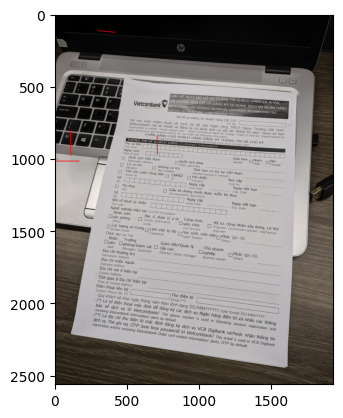

In [407]:
#getQuadrangleByLength([tl],[bl],[ll],[rl],src)

debugImg= src.copy()
drawLinePoint(debugImg,[tl[0:4]],(0,0,255),3)
drawLinePoint(debugImg,[bl[0:4]],(0,0,255),3)
drawLinePoint(debugImg,[ll[0:4]],(0,0,255),3)
drawLinePoint(debugImg,[rl[0:4]],(0,0,255),3)
plt.imshow(cv2.cvtColor(debugImg,cv2.COLOR_BGR2RGB))
plt.show()

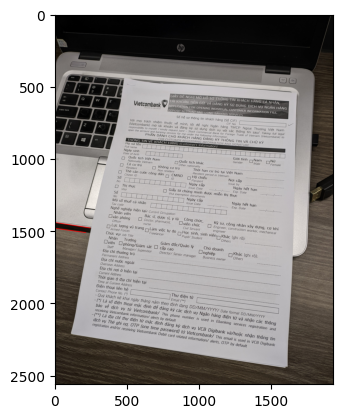

[[   0 1482  213 1512]
 [   0 1442  244 1480]
 [   0 1445  249 1476]
 [   0 1481  243 1516]
 [   0 1446  247 1481]
 [   0 1486  235 1515]
 [   0 1441  247 1480]
 [   1 1481  239 1514]
 [   4 1440  249 1474]
 [   4 1445  247 1475]
 [   4 1439  250 1473]
 [  14 1449  243 1481]
 [  41 1492  244 1517]
 [ 107 2214 1593 2449]
 [ 107 2212  375 2255]
 [ 108 2215 1592 2450]
 [ 113 2217 1592 2451]
 [ 113 2218 1552 2446]
 [ 128 2221 1467 2433]
 [ 331 2254 1259 2401]
 [ 744 2314 1527 2438]
 [1182 2383 1516 2436]]
[[   0. 1482.  244. 1517.]
 [   0. 1442.  250. 1473.]
 [ 107. 2214. 1593. 2449.]]


In [408]:

debugImg1= src.copy()
drawLinePoint(debugImg1,bottomLineList[0:2],(0,0,255),3)
plt.imshow(cv2.cvtColor(debugImg1,cv2.COLOR_BGR2RGB))
plt.show()

print(bottomLineList)
print(mergedBottomLineList)

## The Result above

# Detect text component by Morphology
- https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/


Total labels: 1309
[INFO] keeping connected component '2'- (w,h,area) =(116,45,2104)
[INFO] keeping connected component '3'- (w,h,area) =(15,15,151)
[INFO] keeping connected component '28'- (w,h,area) =(452,399,97827)
[INFO] keeping connected component '80'- (w,h,area) =(6,34,50)
[INFO] keeping connected component '85'- (w,h,area) =(54,40,467)
[INFO] keeping connected component '93'- (w,h,area) =(55,43,591)
[INFO] keeping connected component '119'- (w,h,area) =(122,12,299)
[INFO] keeping connected component '125'- (w,h,area) =(50,127,3010)
[INFO] keeping connected component '140'- (w,h,area) =(14,10,87)
[INFO] keeping connected component '163'- (w,h,area) =(67,9,246)
[INFO] keeping connected component '167'- (w,h,area) =(101,9,169)
[INFO] keeping connected component '168'- (w,h,area) =(11,8,34)
[INFO] keeping connected component '173'- (w,h,area) =(7,6,31)
[INFO] keeping connected component '175'- (w,h,area) =(25,17,157)
[INFO] keeping connected component '178'- (w,h,area) =(7,6,27)
[I

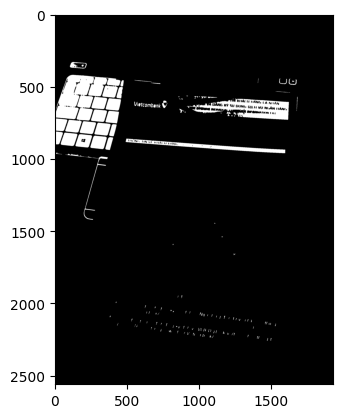

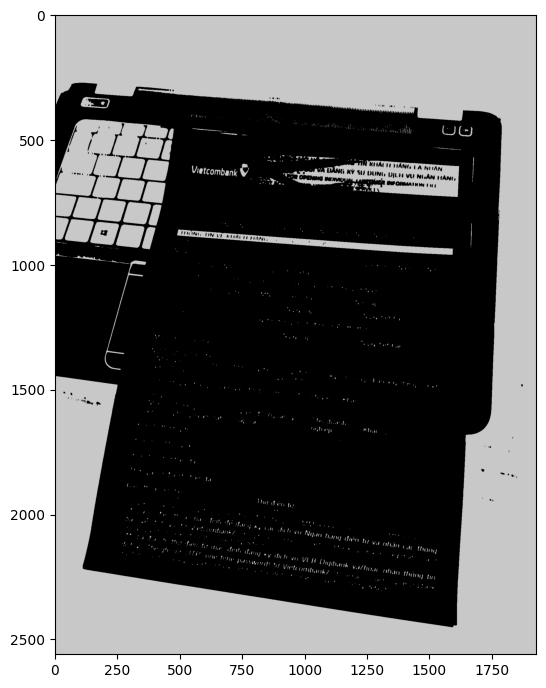

In [409]:
#smallSrc=cv2.resize(src,(int(0.5*src.shape[1]),int(0.5*src.shape[0])))
#filename = r"D:\Google-drive-huy-work\imagedata\eclaim\hoadon\img6.jpg"
#src2 = cv2.imread(filename)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
blurImg = cv2.blur(gray,(5,5),0)
#erodeImg= cv2.erode(blurImg,(3,15),iterations=1)
erodeImg= cv2.morphologyEx(blurImg, cv2.MORPH_OPEN, (3,15), iterations=5)
ret1,thresh = cv2.threshold(erodeImg,40,200, cv2.THRESH_OTSU  + cv2.THRESH_BINARY_INV)

mask = np.zeros(gray.shape, dtype="uint8")
output = cv2.connectedComponentsWithStats(
	thresh,4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
# loop over the number of unique connected component labels
print("Total labels:",numLabels)
for i in range(1, numLabels):
	# extract the connected component statistics and centroid for
	# the current label
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]
	(cX, cY) = centroids[i]
	keepWidth = w > 5 
	keepHeight = h > 5 and h <500
	keepArea = area > 25 
	if all((keepWidth, keepHeight,keepArea)):
		# construct a mask for the current connected component and
		# then take the bitwise OR with the mask
		print("[INFO] keeping connected component '{}'- (w,h,area) =({},{},{})".format(i,w,h,area))
		componentMask = (labels == i).astype("uint8") * 255
		mask = cv2.bitwise_or(mask, componentMask)

	
plt.imshow(mask,cmap='gray')
plt.show()

plt.figure(figsize=figSizeA4)
plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB))
plt.show()

# Test with SmartDoc Dataset

In [410]:
import xml.dom.minidom
import xml.etree.ElementTree as ET
from pathlib import Path 


In [411]:

def eval2Point(p1,p2):
    maxDis=30 # max distance from p1 to p2
    confident=0.0
    l=getLineLength(p1,p2)
    if(l<=maxDis):
        confident=((maxDis-l)/maxDis)
    return confident

def get_confidence_2quard(quadr_true,quadr_pred):
    (tl_pred,tr_pred,br_pred,bl_pred)=quadr_pred
    (tl,tr,br,bl)=quadr_true
    tl_c=(eval2Point(tl_pred,tl))
    tr_c=(eval2Point(tr_pred,tr))
    br_c=(eval2Point(br_pred,br))
    bl_c=(eval2Point(bl_pred,bl))

    mean_c=(tl_c+tr_c+br_c+bl_c)/4
    return mean_c


In [412]:
%%script echo skip

def getListGroundTruth(xmlfile):
    """
        returns:
            list frame points in order [tl,tr,br,bl]. 
    """
    gtList=[]
    doc = xml.dom.minidom.parse(xmlfile)
    frameList = doc.getElementsByTagName("frame")
    for frame in frameList:
        bl=[]
        tl=[]
        tr=[]
        br=[]
        pointList = frame.getElementsByTagName("point")
        for p in pointList:
            name = p.getAttribute("name")
            x= float(p.getAttribute("x"))
            y= float(p.getAttribute("y"))
            if(name=="bl"):
                bl = [x, y]
            elif name == "tl":
                tl =[x,y]
            elif name =="tr":
                tr =[x,y]
            elif name =="br":
                br=[x,y]
        gtList.append([tl,tr,br,bl])
    return gtList
    

videoFile =r"d:\ImageData\SmartDoc\background01\datasheet001.avi"
gtfile = r"D:\ImageData\SmartDoc\background01\datasheet004.gt.xml"
savedImagePath=r"d:\ImageData\SmartDoc\background01\datasheet001\\"
gtList =getListGroundTruth(gtfile)
gtList = np.asarray( gtList)

video = cv2.VideoCapture(videoFile)
videoName =Path(videoFile).name

# Check if camera opened successfully
if (video.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
numdebug=0
 
frame_width = int(video.get(3))
frame_height = int(video.get(4))
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter(r'D:/test/'+videoName,cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

frameIdx=0
confidenceList=[] 
while(video.isOpened()):
  # Capture frame-by-frame
  print('Reading frame...')
  ret, frame = video.read()
  if ret == True:
    numdebug +=1
    frameIdx +=1
    print("Processing frame: ", frameIdx)
    outImageFile = savedImagePath + "frame_{}.jpg".format(frameIdx)
    #cv2.imwrite(outImageFile,frame)

    # cropedImg,debugImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint),hasCropped=cropDocument(frame)
    # (tl,tr,br,bl)=gtList[frameIdx-1]
    # #calculate metric IoU
    # confidence=get_confidence_2quard((tl,tr,br,bl),(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint))
    # print("Frame {} \t Confidence: {}".format(frameIdx,confidence))
    # confidenceList.append(confidenceList)
    # # Display the resulting frame
    # out.write(debugImg)
    # if(numdebug<10):
    #    plt.imshow(debugImg)
    #    plt.show()
    # Press Q on keyboard to  exit
 
  # Break the loop
  else: 
    break

print('Confidence mean:',np.mean(confidenceList))

# When everything done, release the video capture object
video.release()
out.release()



Couldn't find program: 'echo'
